In [85]:
%load_ext autoreload
%autoreload 2

import os

subj = "phase2/Subj6"

UNIQUE_VALUES_THRESHOLD = 200

exp = "exp_reduced_flow"
os.makedirs(f"{subj}/{exp}", exist_ok = True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import typing

import mne
import numpy
import pandas
import IPython.display
import sklearn.metrics
import matplotlib.colors
import sklearn.preprocessing
import sklearn.decomposition
import matplotlib.pyplot as plt

import SDA.topology
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

### Data

Reading d:\HSE\year-3\HSE\CourseProject\phase2\Subj5\src\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     498.00 ms
        0 CTF compensation matrices available
Not setting metadata
1651 matching events found
No baseline correction applied
0 projection items activated
Stages:  9
No projector specified for this dataset. Please consider the method self.add_proj.


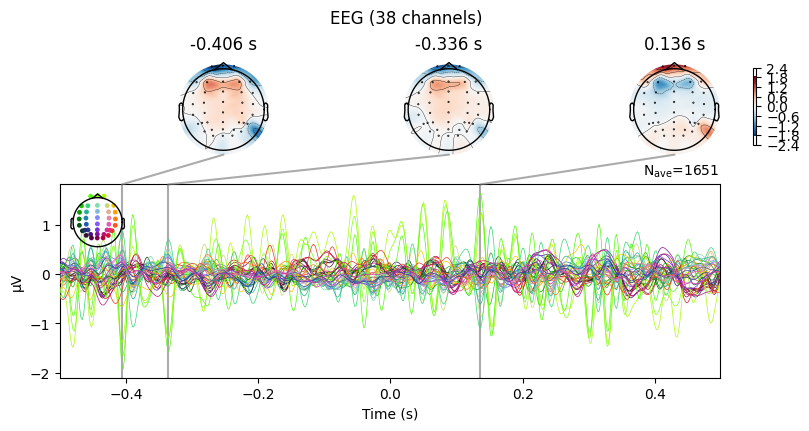

(1651, 38, 500)


In [87]:
epochs = mne.read_epochs(f"{subj}/src/epochs_filt_rr-epo.fif").drop_channels(ch_names = [ 'IVEOG', 'IHEOG' ])
N_STAGES = int(numpy.loadtxt(f"{subj}/src/n_stages.txt"))
print('Stages: ', N_STAGES)

epochs.average().plot_joint().savefig(f"{subj}/{exp}/eeg.svg")
data = epochs.get_data(copy = True)
print(data.shape)

### Features

In [88]:
per_channel_folder = f"{subj}/{exp}/features/per_channel"
os.makedirs(per_channel_folder, exist_ok = True)
per_channel_extractor = SDA.topology.PerChannelFeatureExtractor(n_jobs = -1, folder = per_channel_folder, reduced = True)
per_channel_features = per_channel_extractor.extract(data)

dissimilarity_folder = f"{subj}/{exp}/features/dissimilarity"
os.makedirs(dissimilarity_folder, exist_ok = True)
dissimilarity_extractor = SDA.topology.DissimilarityFeatureExtractor(n_jobs = -1, folder = dissimilarity_folder, reduced = True)
dissimilarity_features = dissimilarity_extractor.extract(data)

overall_folder = f"{subj}/{exp}/features/overall"
os.makedirs(overall_folder, exist_ok = True)
overall_extractor = SDA.topology.OverallFeatureExtractor(n_jobs = -1, folder = overall_folder, reduced = True)
overall_features = overall_extractor.extract(data)

all_features = pandas.concat([
    per_channel_features,
    dissimilarity_features,
    overall_features
], axis = 1)

all_features.to_feather(f"{subj}/{exp}/features/all_features.feather")
display(all_features)

Got features from phase2/Subj5/exp_reduced_flow/features/per_channel/features.feather
Got features from phase2/Subj5/exp_reduced_flow/features/overall/features.feather


,channel-0 landscape dim-1 max,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 landscape dim-2 max,channel-0 landscape dim-2 mean,channel-0 landscape dim-2 std,channel-0 landscape dim-2 sum,...,overall bd2 dim-2 std,overall bd2 dim-2 sum,overall bd2 dim-2 norm-1,overall bd2 dim-2 norm-2,overall bd2 dim-3 max,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,0.000013,7.365937e-07,2.418858e-06,0.000074,0.000074,0.000025,0.000004,1.163325e-07,6.030687e-07,0.000012,...,0.000023,0.005522,0.005522,0.001033,0.000230,0.000203,0.000017,0.001418,0.001418,0.000538
1,0.000007,4.290241e-07,1.463423e-06,0.000043,0.000043,0.000015,0.000003,1.334968e-07,4.710378e-07,0.000013,...,0.000014,0.010927,0.010927,0.001392,0.000220,0.000188,0.000015,0.003198,0.003198,0.000778
2,0.000004,1.201919e-07,6.138129e-07,0.000012,0.000012,0.000006,0.000002,4.295969e-08,2.286759e-07,0.000004,...,0.000011,0.006195,0.006195,0.000855,0.000135,0.000117,0.000007,0.001756,0.001756,0.000454
3,0.000006,1.609143e-07,8.200182e-07,0.000016,0.000016,0.000008,0.000003,8.174574e-08,4.066540e-07,0.000008,...,0.000012,0.004499,0.004499,0.000743,0.000176,0.000134,0.000019,0.000941,0.000941,0.000359
4,0.000006,2.447434e-07,9.268250e-07,0.000024,0.000024,0.000010,0.000001,5.941026e-08,2.355490e-07,0.000006,...,0.000012,0.008284,0.008284,0.001101,0.000179,0.000158,0.000011,0.001739,0.001739,0.000526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,0.000009,4.545220e-07,1.612824e-06,0.000045,0.000045,0.000017,0.000005,1.631915e-07,7.084878e-07,0.000016,...,0.000017,0.011662,0.011662,0.001537,0.000245,0.000214,0.000018,0.002778,0.002778,0.000773
1647,0.000006,2.238002e-07,1.006579e-06,0.000022,0.000022,0.000010,0.000002,9.452193e-08,3.886324e-07,0.000009,...,0.000014,0.008484,0.008484,0.001204,0.000192,0.000175,0.000008,0.002800,0.002800,0.000701
1648,0.000007,3.073816e-07,1.252682e-06,0.000031,0.000031,0.000013,0.000004,1.488619e-07,5.722973e-07,0.000015,...,0.000008,0.010365,0.010365,0.001328,0.000197,0.000184,0.000006,0.003124,0.003124,0.000758
1649,0.000005,2.523416e-07,8.840282e-07,0.000025,0.000025,0.000009,0.000002,5.936996e-08,3.018521e-07,0.000006,...,0.000006,0.009082,0.009082,0.001164,0.000165,0.000156,0.000004,0.002963,0.002963,0.000680


In [89]:
features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
features = pandas.DataFrame(features, columns = all_features.columns)

features.to_feather(f"{subj}/{exp}/features/features.feather")
display(features)

numpy.save(f"{subj}/{exp}/features/features.npy", features.to_numpy())

,channel-0 landscape dim-1 max,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 landscape dim-2 max,channel-0 landscape dim-2 mean,channel-0 landscape dim-2 std,channel-0 landscape dim-2 sum,...,overall bd2 dim-2 std,overall bd2 dim-2 sum,overall bd2 dim-2 norm-1,overall bd2 dim-2 norm-2,overall bd2 dim-3 max,overall bd2 dim-3 mean,overall bd2 dim-3 std,overall bd2 dim-3 sum,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,1.937867,0.804553,1.528317,0.804553,0.804553,1.371606,1.642581,0.379121,1.092006,0.379121,...,1.331338,-0.153320,-0.153320,0.307046,1.107258,1.037123,0.964062,-0.273610,-0.273610,0.136753
1,0.457453,0.317237,0.611379,0.317237,0.317237,0.545824,0.492800,0.513561,0.648664,0.513561,...,0.265784,1.053031,1.053031,1.112562,0.954507,0.775171,0.752757,0.575040,0.575040,0.864002
2,-0.135936,-0.172081,-0.203999,-0.172081,-0.172081,-0.194404,0.009027,-0.195573,-0.165154,-0.195573,...,-0.105033,-0.003273,-0.003273,-0.093728,-0.377184,-0.510240,-0.153035,-0.112918,-0.112918,-0.117195
3,0.213629,-0.107559,-0.006102,-0.107559,-0.107559,-0.021443,0.449773,0.108220,0.432472,0.108220,...,0.017029,-0.381717,-0.381717,-0.343632,0.257987,-0.195151,1.221798,-0.501125,-0.501125,-0.404014
4,0.170061,0.025260,0.096401,0.025260,0.025260,0.079722,-0.335594,-0.066723,-0.142075,-0.066723,...,0.047141,0.463126,0.463126,0.459490,0.306202,0.232563,0.321350,-0.120597,-0.120597,0.099783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,0.995566,0.357636,0.754760,0.357636,0.357636,0.669778,2.055895,0.746145,1.445989,0.746145,...,0.553067,1.217155,1.217155,1.436536,1.337237,1.236811,1.119483,0.374523,0.374523,0.848983
1647,0.224275,-0.007922,0.172942,-0.007922,-0.007922,0.139434,0.317509,0.208289,0.371958,0.208289,...,0.263464,0.507638,0.507638,0.690063,0.519499,0.537525,-0.068933,0.385049,0.385049,0.629306
1648,0.557724,0.124505,0.409129,0.124505,0.124505,0.352303,1.643266,0.633908,0.988680,0.633908,...,-0.501190,0.927668,0.927668,0.969434,0.590740,0.695956,-0.307268,0.539521,0.539521,0.802919
1649,-0.118053,0.037299,0.055329,0.037299,0.037299,0.047417,0.124040,-0.067039,0.080562,-0.067039,...,-0.660232,0.641299,0.641299,0.600131,0.090369,0.192862,-0.467910,0.462625,0.462625,0.566503


### Feature selection

In [90]:
os.makedirs(f"{subj}/{exp}/qsda", exist_ok = True)
qsda = SDA.QSDA(
    n_jobs = 1,
    qsda_n_jobs = 15,
    scores_folder = f"{subj}/{exp}/qsda",

    threshold = 1150,
    min_unique_values = UNIQUE_VALUES_THRESHOLD
)
best_features, scores = qsda.select(features)

best_features.to_feather(f"{subj}/{exp}/qsda/best_features.feather")
numpy.save(f"{subj}/{exp}/qsda/best_features.npy", features.to_numpy())
display(best_features)
display(scores)

Using threshold 0.43


,channel-0 landscape dim-1 mean,channel-0 landscape dim-1 std,channel-0 landscape dim-1 sum,channel-0 landscape dim-1 norm-1,channel-0 landscape dim-1 norm-2,channel-0 landscape dim-2 mean,channel-0 landscape dim-2 sum,channel-0 landscape dim-2 norm-1,channel-0 silhouette-1 dim-1 mean,channel-0 silhouette-1 dim-1 std,...,overall bd2 dim-1 norm-2,overall bd2 dim-2 max,overall bd2 dim-2 mean,overall bd2 dim-2 sum,overall bd2 dim-2 norm-1,overall bd2 dim-2 norm-2,overall bd2 dim-3 mean,overall bd2 dim-3 sum,overall bd2 dim-3 norm-1,overall bd2 dim-3 norm-2
0,0.804553,1.528317,0.804553,0.804553,1.371606,0.379121,0.379121,0.379121,0.837230,1.806290,...,0.647013,1.238160,1.228238,-0.153320,-0.153320,0.307046,1.037123,-0.273610,-0.273610,0.136753
1,0.317237,0.611379,0.317237,0.317237,0.545824,0.513561,0.513561,0.513561,0.158863,0.372535,...,0.750158,0.932313,0.882871,1.053031,1.053031,1.112562,0.775171,0.575040,0.575040,0.864002
2,-0.172081,-0.203999,-0.172081,-0.172081,-0.194404,-0.195573,-0.195573,-0.195573,-0.136315,-0.282698,...,-0.321573,-0.293104,-0.562223,-0.003273,-0.003273,-0.093728,-0.510240,-0.112918,-0.112918,-0.117195
3,-0.107559,-0.006102,-0.107559,-0.107559,-0.021443,0.108220,0.108220,0.108220,-0.074183,-0.058408,...,0.037244,-0.364925,-0.447332,-0.381717,-0.381717,-0.343632,-0.195151,-0.501125,-0.501125,-0.404014
4,0.025260,0.096401,0.025260,0.025260,0.079722,-0.066723,-0.066723,-0.066723,-0.016479,0.074318,...,0.466508,0.277087,0.130508,0.463126,0.463126,0.459490,0.232563,-0.120597,-0.120597,0.099783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1646,0.357636,0.754760,0.357636,0.357636,0.669778,0.746145,0.746145,0.746145,0.282612,0.678719,...,1.249959,1.421148,1.487383,1.217155,1.217155,1.436536,1.236811,0.374523,0.374523,0.848983
1647,-0.007922,0.172942,-0.007922,-0.007922,0.139434,0.208289,0.208289,0.208289,0.069715,0.377685,...,1.127085,0.729950,0.722927,0.507638,0.507638,0.690063,0.537525,0.385049,0.385049,0.629306
1648,0.124505,0.409129,0.124505,0.124505,0.352303,0.633908,0.633908,0.633908,0.130643,0.435461,...,0.873042,0.387945,0.729068,0.927668,0.927668,0.969434,0.695956,0.539521,0.539521,0.802919
1649,0.037299,0.055329,0.037299,0.037299,0.047417,-0.067039,-0.067039,-0.067039,-0.079978,-0.203437,...,0.592106,0.023156,0.217063,0.641299,0.641299,0.600131,0.192862,0.462625,0.462625,0.566503


,name,score,mean,variance,unique_values,normalized_score
0,channel-0 landscape dim-1 max,1.823168,-3.442969e-17,1.0,1651,0.384695
1,channel-0 landscape dim-1 mean,2.583040,-8.607423e-18,1.0,1651,0.550354
2,channel-0 landscape dim-1 std,2.690171,-1.032891e-16,1.0,1651,0.573709
3,channel-0 landscape dim-1 sum,2.583040,8.607423e-18,1.0,1651,0.550354
4,channel-0 landscape dim-1 norm-1,2.583040,8.607423e-18,1.0,1651,0.550354
...,...,...,...,...,...,...
4639,overall bd2 dim-3 mean,2.079167,-2.410078e-16,1.0,1563,0.440505
4640,overall bd2 dim-3 std,0.724778,-6.885938e-17,1.0,1452,0.145236
4641,overall bd2 dim-3 sum,2.244333,-6.885938e-17,1.0,1563,0.476513
4642,overall bd2 dim-3 norm-1,2.244333,-6.885938e-17,1.0,1563,0.476513


### Results

#### Estimator

In [91]:
def analyze(all_features: pandas.DataFrame, n_components: int, folder: str):
    folder = f"{subj}/{exp}/results/{folder}"
    os.makedirs(folder, exist_ok = True)

    # Scale features
    all_features = sklearn.preprocessing.StandardScaler().fit_transform(all_features)
    print(all_features.shape)
    numpy.save(f"{folder}/all_features.npy", all_features)
    numpy.savetxt(f"{folder}/all_features_shape.txt", all_features.shape)

    # PCA
    pca = sklearn.decomposition.PCA(n_components = n_components, svd_solver = "full", random_state = 42)
    pca_features = pca.fit_transform(all_features)
    print(pca_features.shape)
    numpy.save(f"{folder}/pca_features.npy", pca_features)
    numpy.savetxt(f"{folder}/pca_features_shape.txt", pca_features.shape)
    
    print('Explained variance', round(pca.explained_variance_ratio_.sum(), 2))
    print([ round(x, 3) for x in pca.explained_variance_ratio_ ])
    numpy.savetxt(f"{folder}/explained_variance.txt", [ pca.explained_variance_ratio_.sum() ])
    numpy.savetxt(f"{folder}/explained_variance_ratios.txt", pca.explained_variance_ratio_)

    # SDA
    sda = SDA.SDA(n_jobs = -1, scale = False, verbose = True)
    results, df_st_edges = sda.apply(pca_features)
    
    results.to_csv(f"{folder}/results.csv")
    df_st_edges.to_csv(f"{folder}/df_st_edges.csv")

    # Analyze
    best_results = SDA.analytics.best_results(results, key = 'Avg-Silh')
    best_results.to_csv(f"{folder}/best_results.csv")
    
    best_result = SDA.analytics.best_result(results, key = 'Avg-Silh', n_stages = N_STAGES)
    best_result_df = pandas.DataFrame([ best_result ])
    best_result_df.to_csv(f"{folder}/best_result.csv")
    display(best_result_df)
    
    best_edges = numpy.array(best_result['St_edges'])
    numpy.savetxt(f"{folder}/best_edges.txt", best_edges, fmt = "%d", newline = ' ')
    display(best_edges)

    stage_timing = SDA.analytics.stage_timing(best_edges, epochs)
    stage_timing.to_csv(f"{folder}/stage_timing.csv")
    display(stage_timing)
    
    SDA.analytics.plot_stats(pca_features, epochs, best_result, df_st_edges).savefig(f"{folder}/stats.svg")

#### Традиционные признаки

(1651, 341)
(1651, 15)
Explained variance 0.81
[0.344, 0.165, 0.072, 0.043, 0.036, 0.029, 0.025, 0.023, 0.014, 0.013, 0.011, 0.01, 0.01, 0.009, 0.008]
Applying to 1651 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:17<00:00, 38.64it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,60,50,15,Median,40,"[0, 141, 259, 593, 685, 1016, 1134, 1318, 1448...",9,334,92,183.444444,12529.466201,12.094626,-0.00521,95.627331,4.214005,0.156323,71.182892,2.377877


array([   0,  141,  259,  593,  685, 1016, 1134, 1318, 1448, 1651])

,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(6.5, 148.5)","(149.5, 272.5)","(273.5, 638.5)","(639.5, 735.5)","(736.5, 1095.5)","(1096.5, 1220.5)","(1221.5, 1417.5)","(1418.5, 1553.5)","(1554.5, 1766.5)"
"Time length, sec",142.0,123.0,365.0,96.0,359.0,124.0,196.0,135.0,212.0
Number of epochs,141,118,334,92,331,118,184,130,203


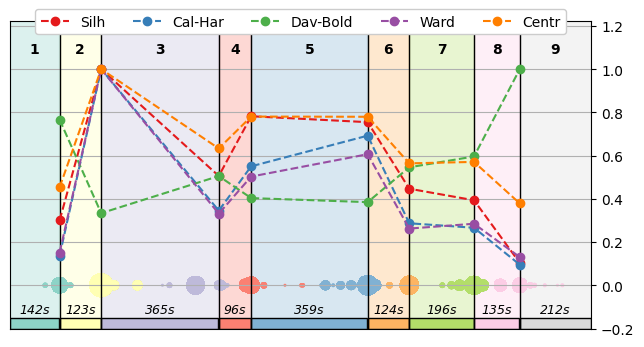

In [92]:
def read_traditional():
    df_ft_psd_loc_db = pandas.read_feather(f'{subj}/src/df_ft_psd_loc_db.feather')
    df_ft_psd_ind_loc_log = pandas.read_feather(f'{subj}/src/df_ft_psd_ind_loc_log.feather')
    df_ft_coh_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_coh_ind_loc.feather')
    df_ft_plv_ind_loc = pandas.read_feather(f'{subj}/src/df_ft_plv_ind_loc.feather')

    result =  pandas.concat([
        df_ft_psd_loc_db,
        df_ft_psd_ind_loc_log,
        df_ft_coh_ind_loc,
        df_ft_plv_ind_loc
    ], axis = 1)

    if subj == "Subj2":
        result = result[:-2]
    return result

analyze(read_traditional(), 15, "traditional")

#### Топологические признаки + QSDA + PCA

(1651, 1131)
(1651, 15)
Explained variance 0.75
[0.376, 0.056, 0.049, 0.04, 0.031, 0.029, 0.027, 0.024, 0.022, 0.021, 0.018, 0.017, 0.016, 0.014, 0.013]
Applying to 1651 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:18<00:00, 36.52it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,60,35,20,Median,40,"[0, 105, 171, 268, 555, 680, 954, 1135, 1322, ...",9,329,66,183.444444,41752.616104,22.433598,-0.073558,115.659235,3.581291,0.23732,79.572142,1.556311


array([   0,  105,  171,  268,  555,  680,  954, 1135, 1322, 1651])

,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(6.5, 111.5)","(112.5, 178.5)","(179.5, 281.5)","(282.5, 599.5)","(600.5, 730.5)","(731.5, 1024.5)","(1025.5, 1221.5)","(1222.5, 1421.5)","(1422.5, 1766.5)"
"Time length, sec",105.0,66.0,102.0,317.0,130.0,293.0,196.0,199.0,344.0
Number of epochs,105,66,97,287,125,274,181,187,329


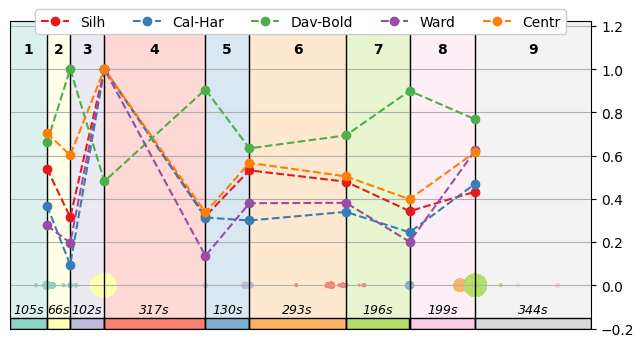

In [93]:
analyze(best_features, 15, "best_topological")

#### Традиционные и топологические вместе + PCA

(1651, 1472)
(1651, 15)
Explained variance 0.71
[0.336, 0.068, 0.05, 0.036, 0.034, 0.026, 0.023, 0.022, 0.02, 0.018, 0.017, 0.016, 0.015, 0.014, 0.013]
Applying to 1651 samples with 15 features each


stage 2: 100%|██████████| 672/672 [00:19<00:00, 34.59it/s]


,St_len_min,K_nb_max,N_cl_max,Cl_cen,Len_min,St_edges,N_stages,Longest_stage,Shortest_stage,Avg_stage_length,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
0,0,50,20,Median,40,"[0, 105, 186, 259, 544, 684, 992, 1135, 1288, ...",9,363,73,183.444444,47855.29649,23.972558,-0.050824,116.835328,4.397779,0.217357,75.849868,1.880148


array([   0,  105,  186,  259,  544,  684,  992, 1135, 1288, 1651])

,0,1,2,3,4,5,6,7,8
"Start-end time, sec","(6.5, 111.5)","(112.5, 193.5)","(194.5, 272.5)","(273.5, 588.5)","(589.5, 734.5)","(735.5, 1071.5)","(1072.5, 1221.5)","(1222.5, 1387.5)","(1388.5, 1766.5)"
"Time length, sec",105.0,81.0,78.0,315.0,145.0,336.0,149.0,165.0,378.0
Number of epochs,105,81,73,285,140,308,143,153,363


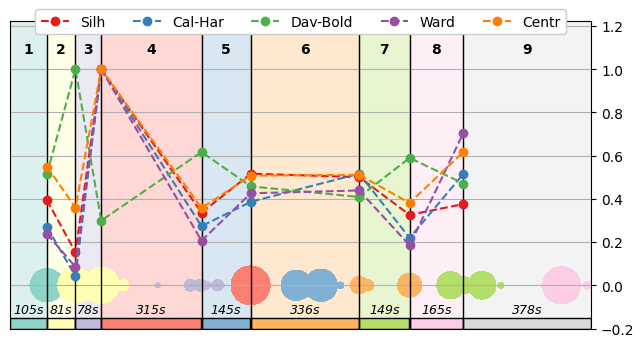

In [94]:
combined_features = pandas.concat([ read_traditional(), best_features ], axis = 1)
analyze(combined_features, 15, "combined")

### Information value

In [95]:
result_edges = numpy.loadtxt(f"{subj}/{exp}/results/best_topological/best_edges.txt").astype(numpy.int32)
print(result_edges)

if os.path.exists(f"{subj}/{exp}/IV/IV.csv"):
    ivs = pandas.read_csv(f"{subj}/{exp}/IV/IV.csv")
else:
    _, labels = SDA.stageprocess.form_stage_bands(result_edges)
    ivs = SDA.analytics.IV.calc_IV_clust(features, labels)

    os.makedirs(f"{subj}/{exp}/IV", exist_ok = True)
    ivs.to_csv(f"{subj}/{exp}/IV/IV.csv", index = False)

ivs["normalized_iv"] = sklearn.preprocessing.MinMaxScaler().fit_transform(ivs[["IV"]])
display(ivs)

[   0  105  171  268  555  680  954 1135 1322 1651]


IV: 100%|██████████| 4644/4644 [00:24<00:00, 190.91it/s]


,Feature,IV,IVs,normalized_iv
0,channel-0 landscape dim-1 max,1.391305,"[1.4299633380530594, 2.938239659424991, 1.4530...",0.606976
1,channel-0 landscape dim-1 mean,1.665364,"[1.7784089445956277, 2.9816895366514435, 1.442...",0.730665
2,channel-0 landscape dim-1 std,1.616186,"[1.736269563635285, 2.9958539011862317, 1.5303...",0.708470
3,channel-0 landscape dim-1 sum,1.665364,"[1.7784089445956277, 2.9816895366514435, 1.442...",0.730665
4,channel-0 landscape dim-1 norm-1,1.665364,"[1.7784089445956277, 2.9816895366514435, 1.442...",0.730665
...,...,...,...,...
4639,overall bd2 dim-3 mean,1.330754,"[1.2496994754819069, 2.9928035073629253, 1.692...",0.579648
4640,overall bd2 dim-3 std,0.627734,"[0.601817791651384, 1.3947095007727317, 1.0856...",0.262359
4641,overall bd2 dim-3 sum,0.930923,"[0.8040200421861807, 1.52429750714706, 1.21867...",0.399195
4642,overall bd2 dim-3 norm-1,0.930923,"[0.8040200421861807, 1.52429750714706, 1.21867...",0.399195


In [96]:
iv_qsda_scores = scores.join(ivs, lsuffix = "name", rsuffix = "Feature")
iv_qsda_scores = iv_qsda_scores[["name", "unique_values", "score", "normalized_score", "IV", "normalized_iv"]]

iv_qsda_scores["score"] = iv_qsda_scores["score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)
iv_qsda_scores["normalized_score"] = iv_qsda_scores["normalized_score"] * (iv_qsda_scores["unique_values"] >= UNIQUE_VALUES_THRESHOLD)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'score', ascending = False)
iv_qsda_scores["QSDA_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores = iv_qsda_scores.sort_values(by = 'IV', ascending = False)
iv_qsda_scores["IV_IDX"] = numpy.arange(1, iv_qsda_scores.shape[0] + 1)

iv_qsda_scores["IDX_DIFF"] = iv_qsda_scores["QSDA_IDX"] - iv_qsda_scores["IV_IDX"]

iv_qsda_scores = iv_qsda_scores.sort_index()
display(iv_qsda_scores)

,name,unique_values,score,normalized_score,IV,normalized_iv,QSDA_IDX,IV_IDX,IDX_DIFF
0,channel-0 landscape dim-1 max,1651,1.823168,0.384695,1.391305,0.606976,1449,430,1019
1,channel-0 landscape dim-1 mean,1651,2.583040,0.550354,1.665364,0.730665,563,235,328
2,channel-0 landscape dim-1 std,1651,2.690171,0.573709,1.616186,0.708470,475,267,208
3,channel-0 landscape dim-1 sum,1651,2.583040,0.550354,1.665364,0.730665,562,232,330
4,channel-0 landscape dim-1 norm-1,1651,2.583040,0.550354,1.665364,0.730665,560,234,326
...,...,...,...,...,...,...,...,...,...
4639,overall bd2 dim-3 mean,1563,2.079167,0.440505,1.330754,0.579648,1074,486,588
4640,overall bd2 dim-3 std,1452,0.724778,0.145236,0.627734,0.262359,3595,1354,2241
4641,overall bd2 dim-3 sum,1563,2.244333,0.476513,0.930923,0.399195,915,938,-23
4642,overall bd2 dim-3 norm-1,1563,2.244333,0.476513,0.930923,0.399195,916,939,-23


<Axes: >

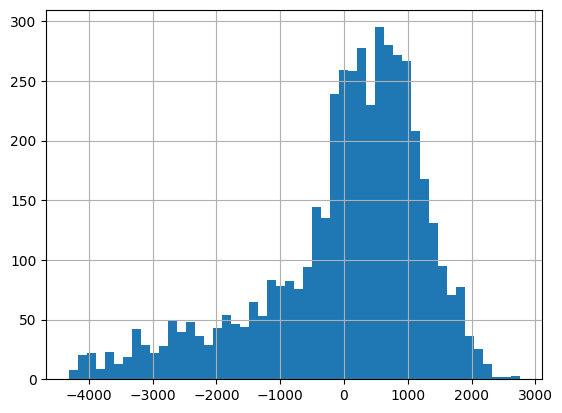

In [97]:
iv_qsda_scores["IDX_DIFF"].hist(bins = 50)

In [98]:
def vec_div(vec):
    mat1 = numpy.repeat(vec.reshape(-1, 1), repeats = len(vec), axis = 1)
    mat2 = numpy.repeat(vec.reshape(1, -1), repeats = len(vec), axis = 0)
    return numpy.sign(mat1 - mat2)

qsda = vec_div(iv_qsda_scores["score"].to_numpy())
iv = vec_div(iv_qsda_scores["IV"].to_numpy())

correct = ((qsda == iv).sum() - iv_qsda_scores.shape[0]) / 2
incorrect = ((qsda != iv).sum() - iv_qsda_scores.shape[0]) / 2

print(correct / 1e6, incorrect / 1e6)

7.545844 3.23288


In [99]:
def sourceFilter(row):
    if row['Source'].startswith('dissim'):
        return 'dissim'
    return row['Source']

iv_qsda_scores[["Source", "Algorithm", "Dimension", "Stat"]] = iv_qsda_scores['name'].str.split(' ', expand = True)
iv_qsda_scores["Source"] = iv_qsda_scores.apply(sourceFilter, axis = 1)
iv_qsda_scores.to_csv(f"{subj}/{exp}/IV/iv_qsda_scores.csv", index = False)

In [100]:
def SourceRenamer(initial: str) -> str:
    if initial == 'dissim':
        return 'Correlations analysis'
    if initial == 'overall':
        return 'Overall processing'
    ind = initial.find('-') + 1
    comp = int(initial[ind:])
    return f'Comp. {comp} (ch. {epochs.ch_names[comp]})'

def AlgorithmRenamer(row):
    return {
        'amplitude-betti-1':        'Betti amp. with p=1',
        'amplitude-betti-2':        'Betti amp. with p=2',

        'amplitude-bottleneck':     'Bottleneck amp.',
        'amplitude-wasserstein-1':  'Wasserstein amp. with p=1',
        'amplitude-wasserstein-2':  'Wasserstein amp. with p=2',
        
        'amplitude-landscape-1-1':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-1-2':  'Pers. landscape amp. with p=1',
        'amplitude-landscape-2-1':  'Pers. landscape amp. with p=2',
        'amplitude-landscape-2-2':  'Pers. landscape amp. with p=2',
        
        'amplitude-silhouette-1-1': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-1-2': 'Pers. silhouette amp. with p=1',
        'amplitude-silhouette-2-1': 'Pers. silhouette amp. with p=2',
        'amplitude-silhouette-2-2': 'Pers. silhouette amp. with p=2',

        'bd2':                      'Stat. char. of (b + d) / 2',
        'life':                     'Stat. char. of lifetimes',
        'betti':                    'Stat. char. of Betti curves',
        'landscape':                'Stat. char. of pers. landscape',
        'silhouette-1':             'Stat. char. of lvl 1 pers. silh.',
        'silhouette-2':             'Stat. char. of lvl 2 pers. silh.',
        
        'entropy':                  'Persistence entropy',
        'numberofpoints':           'Number of points',
    }[row]

def DimensionRenamer(row):
    return {
        'all':        'All',
        'dim-1':      'Dimension 1',
        'dim-2':      'Dimension 2',
        'dim-3':      'Dimension 3',
        'dim-4':      'Dimension 4',
        'dim-5':      'Dimension 5',
        'norm-1':     'Amplitude norm with p=1',
        'norm-2':     'Amplitude norm with p=2',
    }[row]

def StatRenamer(row):
    return {
        'kurtosis':      'Kurtosis',
        'skew':          'Skew',
        'max':           'Maximum',
        'mean':          'Mean',
        'median':        'Median',
        'norm-1':        'Norm with p=1',
        'norm-2':        'Norm with p=2',
        'percentile-25': 'Percentile - 25',
        'percentile-75': 'Percentile - 75',
        'std':           'Standard deviation',
        'sum':           'Sum',
    }[row]

def make_stats(data: pandas.DataFrame, group_by: str, sort_by: str):
    stats = data.groupby(by = group_by).mean(numeric_only = True)
    stats = stats.sort_values(by = sort_by).reset_index()
    stats.to_csv(f"{subj}/{exp}/IV/stats_{group_by}_{sort_by}.csv", index = False)
    return stats

def draw(
    data: pandas.DataFrame,
    group_by: str,
    sort_by: str,
    ax,
    renamer: typing.Callable[[str], str],
    title: str
):
    stats = make_stats(data, group_by, sort_by)
    stats[group_by] = stats[group_by].apply(renamer)
    stats.plot.barh(x = group_by, y = sort_by, ax = ax, xlim = (2 * stats[sort_by].min() / 3, None))

    ax.set_title(title)
    ax.get_legend().remove()
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('')

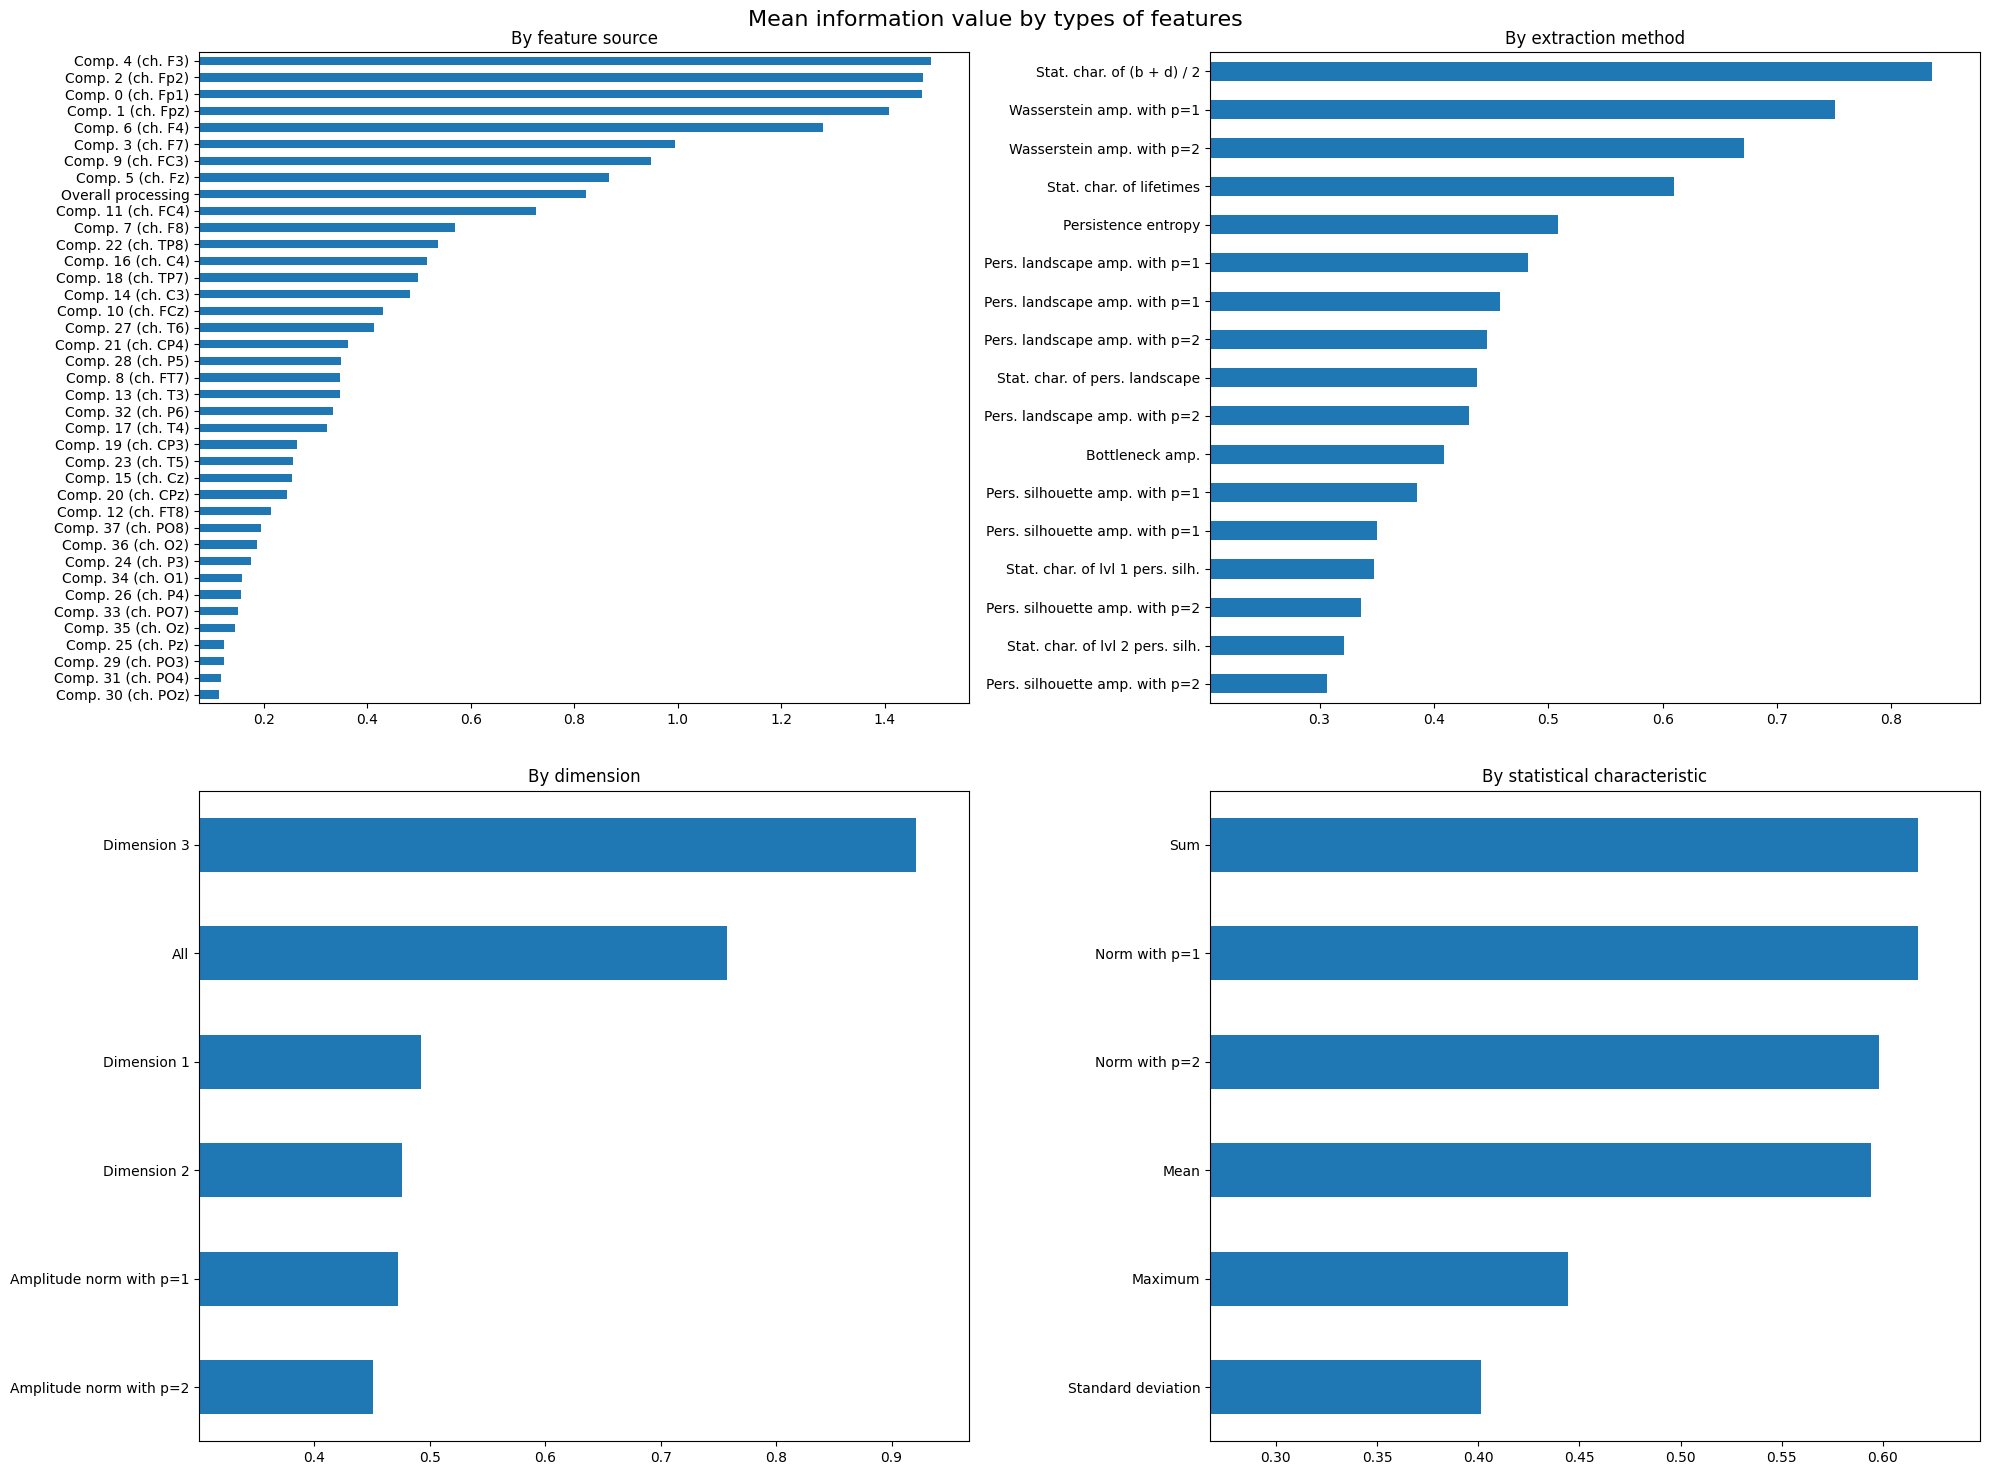

In [101]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Mean information value by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'IV', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'IV', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'IV', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'IV', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_iv.png")

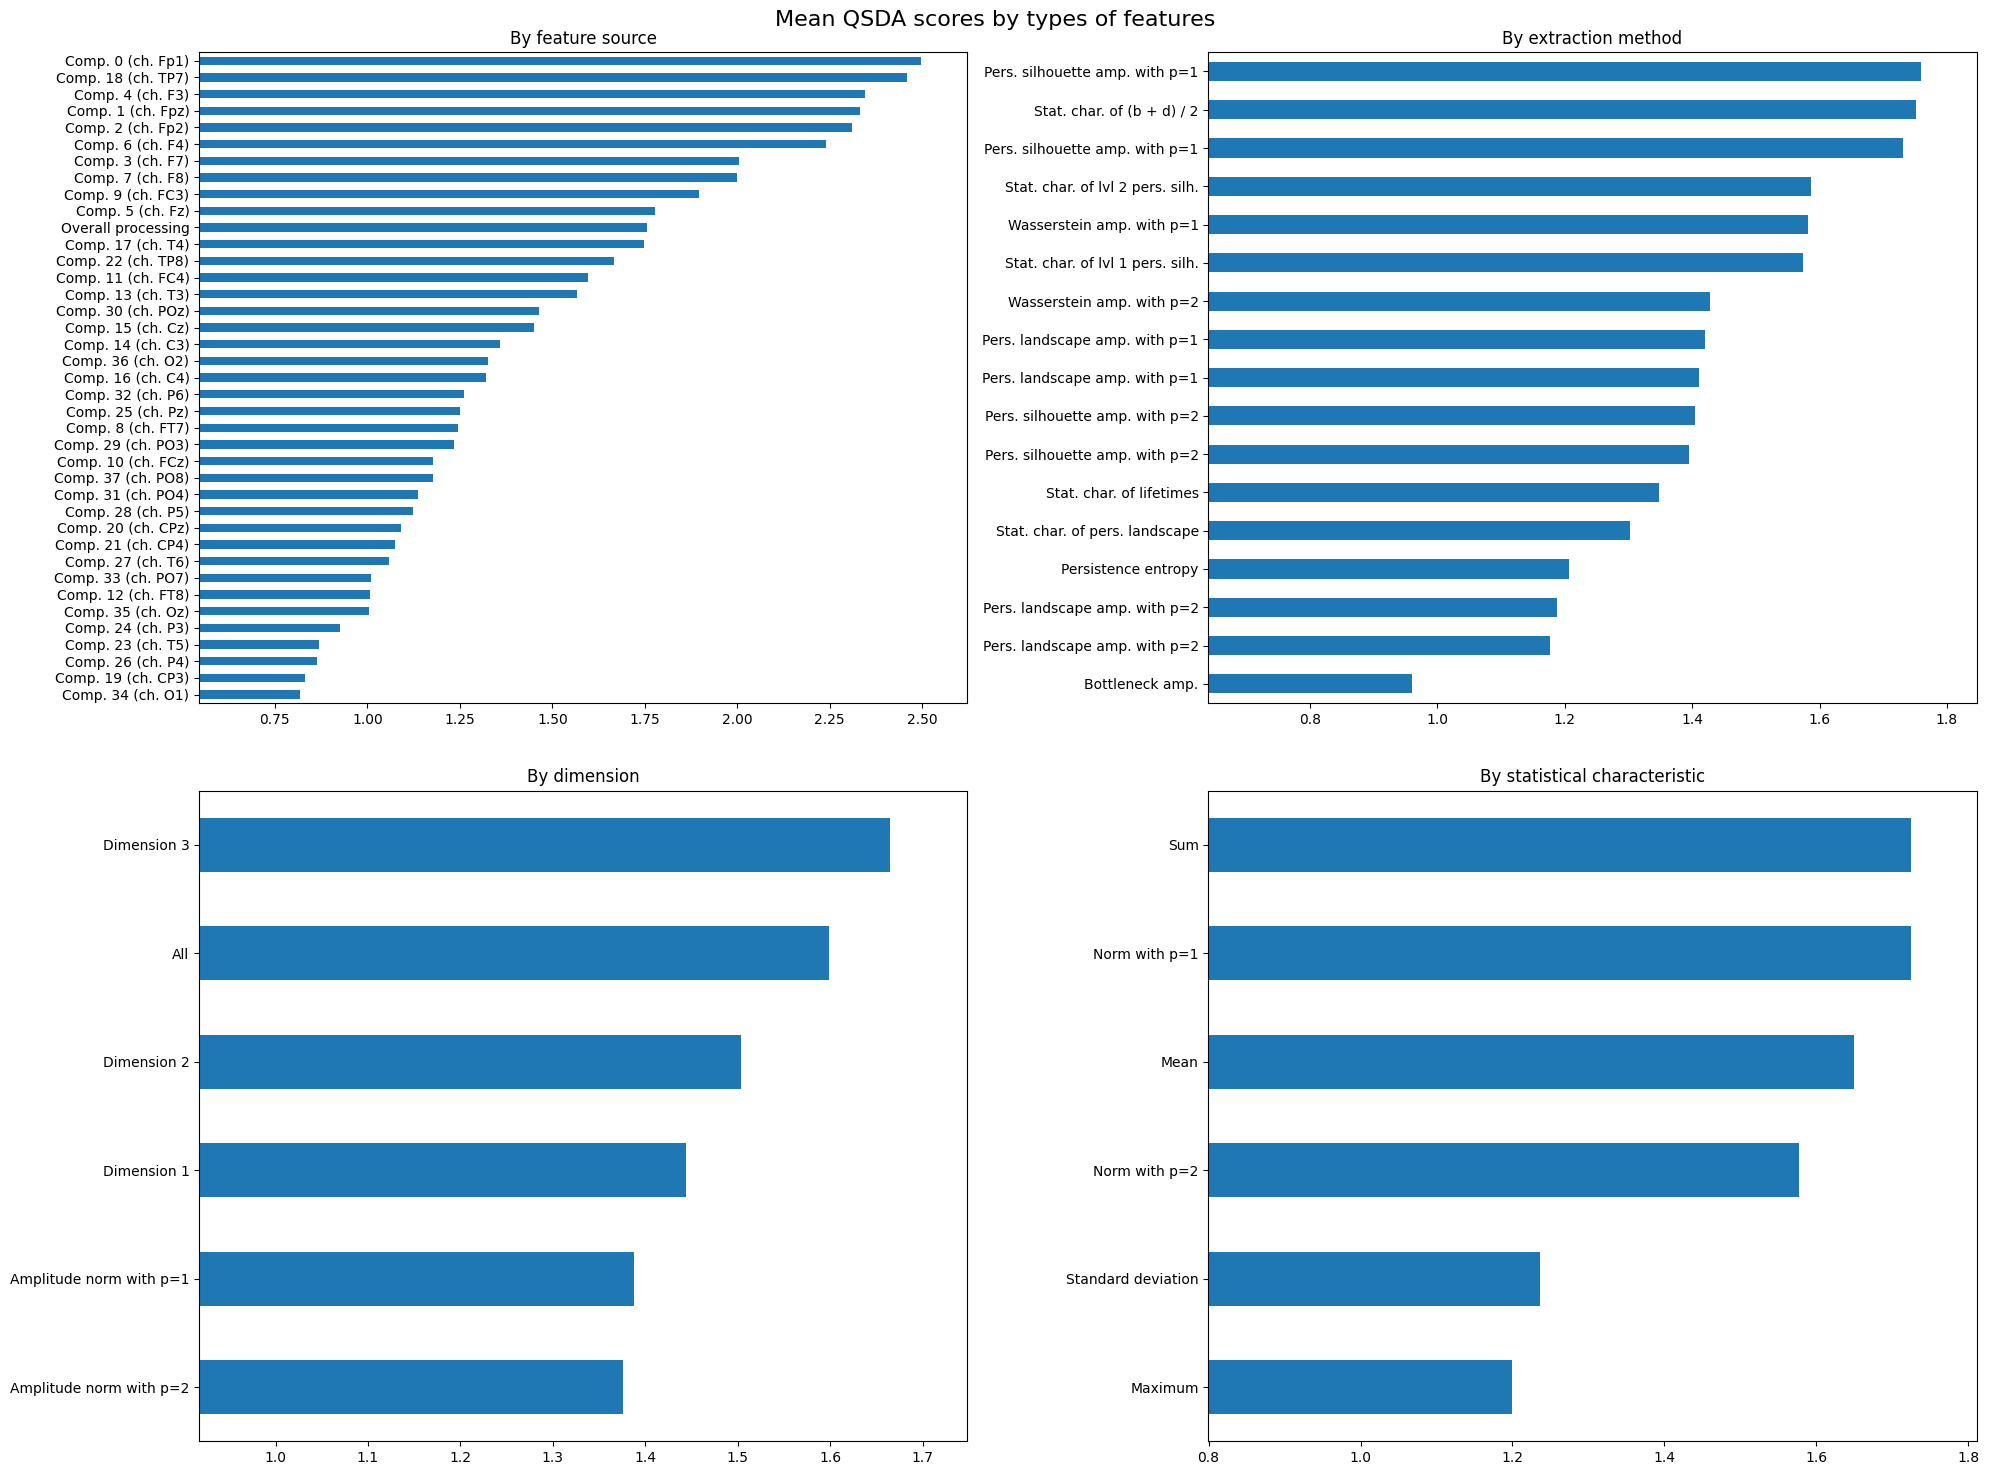

In [102]:
fig, axes = plt.subplots(2, 2, figsize = (20, 15))
fig.suptitle('Mean QSDA scores by types of features', fontsize = 16)

draw(iv_qsda_scores, 'Source', 'score', axes.flat[0], SourceRenamer, 'By feature source')
draw(iv_qsda_scores, 'Algorithm', 'score', axes.flat[1], AlgorithmRenamer, 'By extraction method')
draw(iv_qsda_scores, 'Dimension', 'score', axes.flat[2], DimensionRenamer, 'By dimension')
draw(iv_qsda_scores, 'Stat', 'score', axes.flat[3], StatRenamer, 'By statistical characteristic')

fig.tight_layout(h_pad = 3)
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.svg")
fig.savefig(f"{subj}/{exp}/IV/feature_agg_by_qsda.png")

In [103]:
def draw_sources_heatmap(data: pandas.DataFrame, sort_by: str):
    svg = open("report/regions/regions.svg", "r").read()
    svg = svg[svg.find('>') + 1:svg.rfind('<') - 1]
    defs = ""

    stats = make_stats(data, "Source", sort_by)[["Source", sort_by]]
    stats = stats[stats.apply(lambda row: row['Source'].startswith('channel-'), axis = 1)]

    min, max = stats[sort_by].min(), stats[sort_by].max()
    colors = [[ 1, 0.25, 0 ], [ 1, 0.66, 0 ], [ 1, 0.75, 0 ], [ 0.66, 0.8, 0 ], [ 0.25, 1, 0 ]]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('rg', colors, N = int((max - min) * 1000))

    for _, row in stats.iterrows():
        score = int((row[sort_by] - min) * 1000)
        color = matplotlib.colors.rgb2hex(cmap(score))

        id = int(row['Source'][row['Source'].find('-') + 1:])
        id_index = svg.index(f'id="{id}"')
        path_start = svg.rfind("<", 0, id_index)
        path_end = svg.find(">", id_index)

        path = svg[path_start:path_end+1]
        m_idx = path.find("M")
        x = float(path[m_idx + 1:m_idx + 7])
        y = float(path[m_idx + 8:m_idx + 15])

        defs += f"""
            <radialGradient id="gradient{id}">
                <stop offset="0%" stop-color="{color}" stop-opacity="0.66"></stop>
                <stop offset="100%" stop-color="{color}" stop-opacity="0"></stop>
            </radialGradient>
        """
        part = f"""
            <circle cx="{x}" cy="{y - 2}" r="50" fill="url(#gradient{id})"></circle>
            {path.replace(f'id="{id}"', f'fill="{color}" stroke="{color}"')}
        """

        svg = svg[:path_start] + part + svg[path_end+1:]

    svg = f"""
        <svg viewBox="0 0 530 528" fill="none" xmlns="http://www.w3.org/2000/svg">
            <defs> {defs} </defs> {svg}
        </svg>
    """

    file = f"{subj}/{exp}/IV/{sort_by}_regions.svg"
    open(file, "w").write(svg)
    return IPython.display.SVG(file)

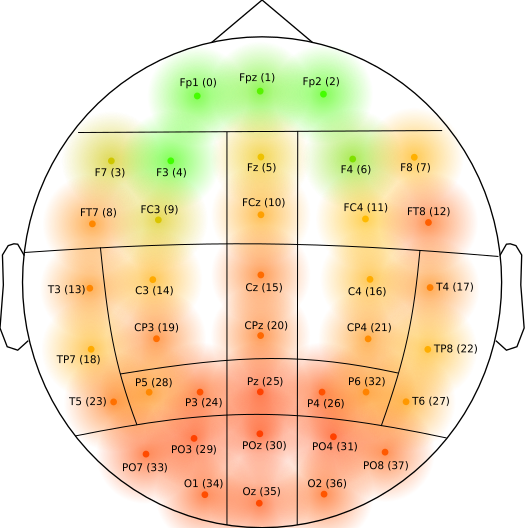

In [104]:
draw_sources_heatmap(iv_qsda_scores, "IV")

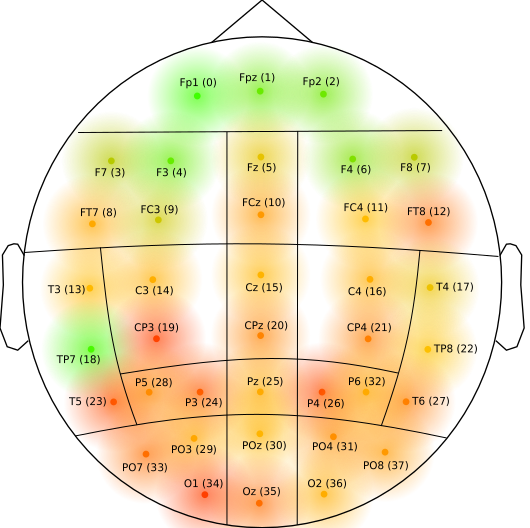

In [105]:
draw_sources_heatmap(iv_qsda_scores, "score")